In [ ]:
# !pip install git+https://github.com/jcmgray/autoray
# !pip install git+https://github.com/jcmgray/cotengra
# !pip install git+https://github.com/jcmgray/quimb
# !pip install nevergrad kahypar

In [ ]:
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn
import autoray as ar
import cotengra as ctg

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97 

Choose prime numbers for D and chi:

In [ ]:
D = 2
chi = 17

Create your tensor network

In [ ]:
L = 5
cyclic = False
edges = qtn.edges_3d_cubic(L, L, L, cyclic=cyclic)
tn = qtn.TN_rand_from_edges(edges, D=D)
tn

<TensorNetworkGen(tensors=125, indices=300)>

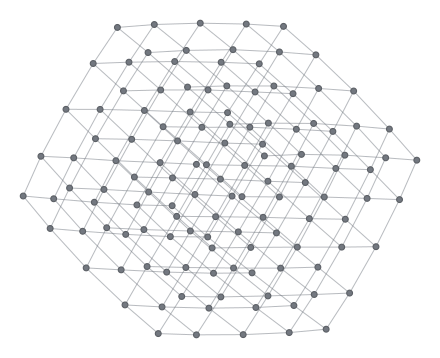

In [ ]:
tn.draw()

In [ ]:
copt = ctg.HyperCompressedOptimizer(
    chi=chi,
    progbar=True,
    minimize='peak-compressed',
    max_repeats=256,
)

INFO:root:Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt


In [ ]:
tree = tn.contraction_tree(copt)

log2[SIZE]: 20.91 log10[FLOPs]: 12.55: 100%|██████████| 256/256 [00:35<00:00,  7.11it/s]


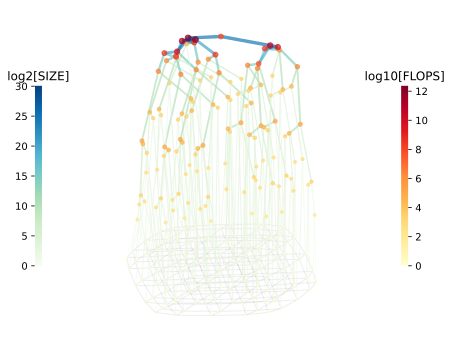

In [ ]:
tree.plot_tent(order=True)

Convert the tensors to lazy arrays:

In [ ]:
tnc = tn.copy()
tnc.apply_to_arrays(ar.lazy.array)

Perform our full contraction (must set `cutoff=0.0`):

In [ ]:
z = tnc.contract_compressed(
    copt.path, 
    max_bond=chi, 
    cutoff=0.0, 
    canonize_distance=2, 
    canonize_after_distance=2,
    gauge_boundary_only=True, 
    progbar=True, 
    equalize_norms=1.0,
)

log2[SIZE]: 0.00/21.26: 100%|██████████| 124/124 [00:00<00:00, 126.82it/s]


Unique computational nodes:

In [ ]:
ops = list(z.ascend())

In [ ]:
len(ops)

13249

In [ ]:
ops[-10:]

[<LazyArray(fn=norm, shape=(), dtype=float64, backend='numpy')>,
 <LazyArray(fn=truediv, shape=(), dtype=float64, backend='numpy')>,
 <LazyArray(fn=truediv, shape=(17, 289), dtype=float64, backend='numpy')>,
 <LazyArray(fn=transpose, shape=(289, 17), dtype=float64, backend='numpy')>,
 <LazyArray(fn=reshape, shape=(4913,), dtype=float64, backend='numpy')>,
 <LazyArray(fn=tensordot, shape=(), dtype=float64, backend='numpy')>,
 <LazyArray(fn=reshape, shape=(1,), dtype=float64, backend='numpy')>,
 <LazyArray(fn=norm, shape=(), dtype=float64, backend='numpy')>,
 <LazyArray(fn=truediv, shape=(), dtype=float64, backend='numpy')>,
 <LazyArray(fn=truediv, shape=(), dtype=float64, backend='numpy')>]

If small we could plot them:

In [ ]:
# z.plot(figsize=(20, 20), initial_layout='kamada_kawai', iterations=10)

We can plot the memory footprint:

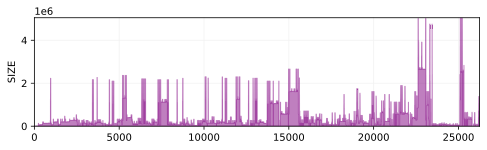

In [ ]:
z.plot_history_size_footprint()

Get the set of functions called:

In [ ]:
{x.fn_name for x in ops}

{'None',
 'getitem',
 'mul',
 'norm',
 'pow',
 'qr',
 'reshape',
 'svd',
 'tensordot',
 'transpose',
 'truediv'}

Assign costs for specific computational functions:

In [ ]:
from functools import reduce
from operator import mul

def prod(it):
    return reduce(mul, it, 1)

def cost_tensordot(x):
    x1, x2, axes = x.args
    shape1, shape2 = x1.shape, x2.shape
    
    cost = prod(shape1) * prod(shape2)
    for d in axes[0]:
        cost //= shape1[d]
        
    return cost

def cost_dense_linear_algebra_decomp(x):
    A, = x.deps
    shape = A.shape
    m = max(shape)
    n = min(shape)
    return m * n **2

def cost_default(x):
    return prod(x.shape)

def cost_nothing(x):
    return 0

def cost(x):
    return {
        'tensordot': cost_tensordot,
        'svd': cost_dense_linear_algebra_decomp,
        'qr': cost_dense_linear_algebra_decomp,
        'getitem': cost_nothing,
    }.get(x.fn_name, cost_default)(x)

Need a function to decompose each cost into its prime factors == (D and chi factors)

In [ ]:
import math
import cytoolz
    
def primeFactors(n):
    fs = []
    if n <= 1:
        return fs
    
    while n % 2 == 0:
        fs.append(2)
        n = n // 2
    for i in range(3,int(math.sqrt(n))+1,2):
        while n % i== 0:
            fs.append(i)
            n = n / i
    if n > 2:
        fs.append(n)
    return fs

List nodes by their cost, output size and number of occurences. Here we can see there are two QRs with cost 
2424307712 that are most expensive.

In [ ]:
freqs = sorted(cytoolz.frequencies(
    (
        cost(x), 
        x.size,
        x.fn_name
    ) for x in ops
).items(), reverse=True)
freqs[:10]

[((2424307712, 2, 'qr'), 2),
 ((342102016, 2515456, 'tensordot'), 3),
 ((342102016, 2, 'qr'), 1),
 ((285212672, 278528, 'tensordot'), 1),
 ((171051008, 628864, 'tensordot'), 4),
 ((171051008, 2, 'qr'), 5),
 ((151519232, 2367488, 'tensordot'), 1),
 ((90870848, 668168, 'tensordot'), 1),
 ((75759616, 278528, 'tensordot'), 4),
 ((75759616, 2, 'qr'), 5)]

For each scaling break down into $D$ and $\chi$ contributing factors:

In [ ]:
scalings = []
for op in freqs:
    scalings.append(
        cytoolz.frequencies(primeFactors(op[0][0]))
    )

Assuming $\chi= D^2$, sort by 'highest' scalings:

In [ ]:
sx = sorted({
    (scaling.get(D, 0) + 2 * scaling.get(chi, 0), f"D={scaling.get(D, 0)} chi={scaling.get(chi, 0)}")
    for scaling in scalings
}, reverse=True)
sx[:20]

[(27, 'D=23 chi=2'),
 (26, 'D=26 chi=0'),
 (26, 'D=24 chi=1'),
 (24, 'D=24 chi=0'),
 (23, 'D=23 chi=0'),
 (23, 'D=21 chi=1'),
 (23, 'D=19 chi=2'),
 (22, 'D=22 chi=0'),
 (22, 'D=20 chi=1'),
 (22, 'D=18 chi=2'),
 (20, 'D=20 chi=0'),
 (20, 'D=18 chi=1'),
 (20, 'D=12 chi=4'),
 (19, 'D=19 chi=0'),
 (19, 'D=17 chi=1'),
 (19, 'D=15 chi=2'),
 (19, 'D=13 chi=3'),
 (19, 'D=11 chi=4'),
 (18, 'D=18 chi=0'),
 (18, 'D=16 chi=1')]